# CNN Model Training

## Import Common Libraries

In [ ]:
import numpy as np

## Define paths

In [ ]:
cnn_features_dir = "../data/features/audio_16k/augmented_mel_spectrograms/audio_features"
metadata_dir = "../data/features/audio_16k/augmented_mel_spectrograms/metadata.csv"
checkpoints_model_dir = "../models/cnn/checkpoints"
final_model_dir = "../models/cnn/final"

## Ensure dir exist

In [ ]:
import os

os.makedirs(checkpoints_model_dir, exist_ok=True)
os.makedirs(final_model_dir, exist_ok=True)

## Load Metadata

In [ ]:
import pandas as pd

df = pd.read_csv(metadata_dir)
df = df[df["dataset"].str.lower() == "crema-d"]
print(f"Total samples: {len(df)}")

## Encode labels for CNN

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Prepare labels
le = LabelEncoder()
y_int = le.fit_transform(df['emotion'])      # convert emotions to integers
y_onehot = to_categorical(y_int) # one-hot encoding for softmax

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(enumerate(class_weights))

num_classes = len(le.classes_)
inverse_map = {idx: cls for idx, cls in enumerate(le.classes_)}

print("Number of classes:", num_classes)
print(inverse_map)

## Train/test split

In [ ]:
# from sklearn.model_selection import train_test_split

# file_paths = df['file_path'].values

# # First split: separate out test set (true holdout)
# train_val_paths, test_paths, y_train_val, y_test = train_test_split(
#     file_paths, y_onehot, test_size=0.10, stratify=y_int, random_state=42
# )

# # Second split: separate train and validation
# train_paths, val_paths, y_train, y_val = train_test_split(
#     train_val_paths, y_train_val, test_size=0.111, stratify=np.argmax(y_train_val, axis=1), random_state=42
# )

# print(f"Training samples: {len(train_paths)}")
# print(f"Validation samples: {len(val_paths)}")
# print(f"Test samples: {len(test_paths)}")

# =============================================================================================================

# With Evenly Distributed Emotions
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Get file paths
file_paths = df['file_path'].values

# First split: separate out test set (10%)
train_val_paths, test_paths, y_train_val, y_test = train_test_split(
    file_paths, 
    y_onehot, 
    test_size=0.10,           # 10% for test
    stratify=y_int,           # Stratify by emotion labels
    random_state=42
)

# Get stratification labels for second split
train_val_labels = np.argmax(y_train_val, axis=1)

# Second split: separate train and validation from remaining 90%
# We want 10% validation of total, which is 0.10/0.90 = 0.1111 of remaining
train_paths, val_paths, y_train, y_val = train_test_split(
    train_val_paths, 
    y_train_val, 
    test_size=0.1111,         # ~11.1% of 90% = 10% of total
    stratify=train_val_labels, # Stratify by emotion
    random_state=42
)

# Print split sizes
print(f"Training samples:   {len(train_paths):4d} ({len(train_paths)/len(file_paths)*100:.1f}%)")
print(f"Validation samples: {len(val_paths):4d} ({len(val_paths)/len(file_paths)*100:.1f}%)")
print(f"Test samples:       {len(test_paths):4d} ({len(test_paths)/len(file_paths)*100:.1f}%)")

# Verify emotion distribution across splits
print("\n=== Emotion Distribution ===")
train_emotions = pd.Series([inverse_map[i] for i in np.argmax(y_train, axis=1)])
val_emotions = pd.Series([inverse_map[i] for i in np.argmax(y_val, axis=1)])
test_emotions = pd.Series([inverse_map[i] for i in np.argmax(y_test, axis=1)])

print("\nTrain:")
print(train_emotions.value_counts().sort_index())
print(f"Total: {len(train_emotions)}")

print("\nValidation:")
print(val_emotions.value_counts().sort_index())
print(f"Total: {len(val_emotions)}")

print("\nTest:")
print(test_emotions.value_counts().sort_index())
print(f"Total: {len(test_emotions)}")

# =============================================================================================================
# from sklearn.model_selection import train_test_split
# import numpy as np

# file_paths = df['file_path'].values
# dataset_types = df['dataset'].values
# emotions = df['emotion'].values

# # Create a combined stratification key: label + dataset type + emotion
# # This ensures all three dimensions are balanced across splits
# stratify_key = [f"{label}_{dataset}_{emotion}" 
#                 for label, dataset, emotion in zip(y_int, dataset_types, emotions)]

# # First split: separate out test set (true holdout)
# train_val_paths, test_paths, y_train_val, y_test, train_val_datasets, test_datasets, train_val_emotions, test_emotions = train_test_split(
#     file_paths, y_onehot, dataset_types, emotions,
#     test_size=0.10, 
#     stratify=stratify_key, 
#     random_state=42
# )

# # Create stratification key for second split
# train_val_stratify = [f"{label}_{dataset}_{emotion}" 
#                       for label, dataset, emotion in zip(
#                           np.argmax(y_train_val, axis=1), 
#                           train_val_datasets, 
#                           train_val_emotions
#                       )]

# # Second split: separate train and validation
# train_paths, val_paths, y_train, y_val, train_datasets, val_datasets, train_emotions, val_emotions = train_test_split(
#     train_val_paths, y_train_val, train_val_datasets, train_val_emotions,
#     test_size=0.111,  # 0.111 of 0.9 ≈ 0.1 of total (10% validation)
#     stratify=train_val_stratify,
#     random_state=42
# )

# print(f"Training samples: {len(train_paths)}")
# print(f"Validation samples: {len(val_paths)}")
# print(f"Test samples: {len(test_paths)}")

# # Verify distribution across all three dimensions
# print("\n=== Dataset Type Distribution ===")
# print("Train:", pd.Series(train_datasets).value_counts().sort_index().to_dict())
# print("Val:  ", pd.Series(val_datasets).value_counts().sort_index().to_dict())
# print("Test: ", pd.Series(test_datasets).value_counts().sort_index().to_dict())

# print("\n=== Emotion Distribution ===")
# print("Train:", pd.Series(train_emotions).value_counts().sort_index().to_dict())
# print("Val:  ", pd.Series(val_emotions).value_counts().sort_index().to_dict())
# print("Test: ", pd.Series(test_emotions).value_counts().sort_index().to_dict())

# print("\n=== Label Distribution ===")
# print("Train:", pd.Series(np.argmax(y_train, axis=1)).value_counts().sort_index().to_dict())
# print("Val:  ", pd.Series(np.argmax(y_val, axis=1)).value_counts().sort_index().to_dict())
# print("Test: ", pd.Series(np.argmax(y_test, axis=1)).value_counts().sort_index().to_dict())

## Create Generators

In [ ]:
import sys
sys.path.append("../src")
import classes
from classes import AudioDataGenerator

train_gen = AudioDataGenerator(train_paths, y_train, batch_size=32, shuffle=True)
val_gen = AudioDataGenerator(val_paths, y_val, batch_size=32, shuffle=False)
test_gen = AudioDataGenerator(test_paths, y_test, batch_size=32, shuffle=False)

print(f"Training batches per epoch: {len(train_gen)}")
print(f"Validation batches per epoch: {len(train_gen)}")
print(f"Test batches: {len(test_gen)}")

## Define CNN Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D, Input

input_shape = (128, 150, 1)

model = Sequential([
    Input(input_shape),

    # BLOCK 1: Early features
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # BLOCK 2: Mid-level features
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # BLOCK 3: High-level features
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    # TRANSITION: 2D → 1D
    GlobalAveragePooling2D(),
    
    # CLASSIFICATION
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

## Compile the model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model.compile(
    optimizer=Adam(learning_rate=0.0001), # Original is 0.0005
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy', 
        patience=15, # Adjusted from 10
        restore_best_weights=True,
        mode='max',
        verbose=1
    ), # Stops training if there is no improvement in 10 epochsa
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=7, # Adjusted from 5
        min_lr=1e-7,
        verbose=1
    ), # Reduces learning rate if there is no improvement on val_loss
    ModelCheckpoint(
        filepath=f"{checkpoints_model_dir}/best_cr_cnn_model.keras", 
        monitor="val_accuracy", 
        save_best_only=True, 
        mode="max", 
        verbose=1
    ) # Saves the best model in the training
]

## Train the Model

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

## Visualize Training History

In [ ]:
import sys

sys.path.append("..")
import utils
from utils import plot_training_history

plot_training_history(history)

## Make Predictions

In [ ]:
from tensorflow.keras.models import load_model

# model = load_model("../models/cnn/final/cnn-ser-model-scrap.keras")


# Predict probabilities
y_pred_prob = model.predict(test_gen)

# Convert to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels as class indices
y_true = np.argmax(y_test, axis=1)

## Evaluate Model

### Accuracy, Precision, Recall, F1-score

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")

### Confusion Matrix

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from plotnine import *

# Convert numeric labels → emotion names
true_labels = [inverse_map[i] for i in y_true]
pred_labels = [inverse_map[i] for i in y_pred]

# Compute confusion matrix
labels = sorted(list(inverse_map.values()))
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Convert to tidy DataFrame for plotnine
df_cm = (
    pd.DataFrame(cm, index=labels, columns=labels)
      .reset_index()
      .melt(id_vars='index')
)

df_cm.columns = ['True', 'Predicted', 'Count']

# Plot confusion matrix
(
    ggplot(df_cm, aes('Predicted', 'True', fill='Count'))
    + geom_tile()
    + geom_text(aes(label='Count'), color='white', size=10)
    + scale_fill_gradient(low='#d0e1f9', high='#023e8a')
    + theme_minimal()
    + labs(title='Confusion Matrix', x='Predicted label', y='True label')
)

### Unweighted Average Recall (UAR)

In [ ]:
uar = recall_score(y_true, y_pred, average='macro')
print(f"Unweighted Average Recall (UAR): {uar:.4f}")

### Detailed classification report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=le.classes_)
print(report)

## Save Model

In [ ]:
model.save("../models/cnn/final/cnn-ser-model.keras")

## Validate model with other dataset

### Initialize Class Predictor

In [1]:
import sys
sys.path.append("../src")
import classes
from classes import CNNAudioPredictor

predictor = CNNAudioPredictor(
    model_path="../models/cnn/final/best_cnn-ser-model.keras",
    class_names=["angry", "disgust", "fear", "happy", "neutral", "sad"],
    target_shape=(128, 150),
    sample_rate=16000
)

2025-12-06 03:39:35.437601: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 03:39:35.488013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 03:39:36.700143: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1764963578.166579   13526 gpu_device.cc:2020] Created device /job:localhost/rep

Model loaded successfully!
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
Model input shape: (None, 128, 150, 1)


### Savee Dataset

#### Get Predictions

In [ ]:
import pandas as pd

df = pd.read_csv('../data/processed/metadata.csv')
df = df[df["dataset"].str.lower() == "savee"]
file_paths = df["file_path"].tolist()

labels_dict = dict(zip(df['file_path'], df['emotion']))

true_labels = df["emotion"].tolist()

results, metrics = predictor.evaluate(
    file_paths=file_paths,
    true_labels=true_labels,
    batch_size=32,
    plot_cm=True,  # Generate visual confusion matrix
    save_cm_path='confusion_matrix.png'  # Save it to file
)

### Emovo Dataset

#### Get Predictions

Predicting on 504 files...
ERROR! Session/line number was not unique in database. History logging moved to new session 17
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step

OVERALL METRICS
Accuracy:  0.3512 (35.12%)
Precision: 0.3784
Recall:    0.3512
F1 Score:  0.3243

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.48      0.48      0.48        84
     disgust       0.14      0.04      0.06        84
        fear       0.27      0.79      0.40        84
       happy       0.38      0.19      0.25        84
     neutral       0.64      0.35      0.45        84
         sad       0.35      0.27      0.31        84

    accuracy                           0.35       504
   macro avg       0.38      0.35      0.32       504
weighted avg       0.38      0.35      0.32       504



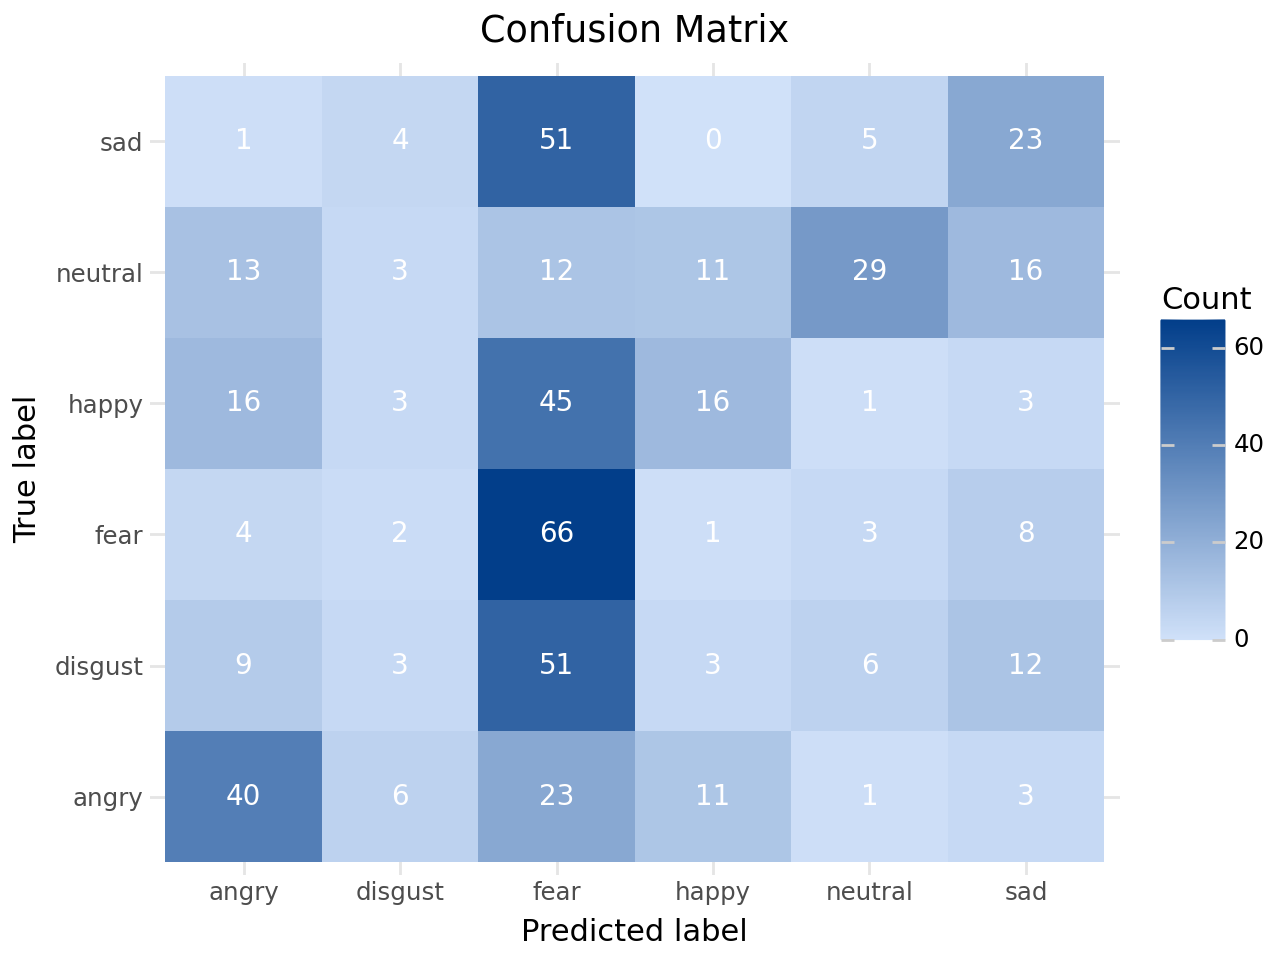


Confusion matrix plot generated!


In [2]:
import pandas as pd

df = pd.read_csv('../data/processed/audio_16k/emovo/metadata.csv')
file_paths = df["file_path"].tolist()

labels_dict = dict(zip(df['file_path'], df['emotion']))

true_labels = df["emotion"].tolist()

results, metrics = predictor.evaluate(
    file_paths=file_paths,
    true_labels=true_labels,
    batch_size=32,
    plot_cm=True,  # Generate visual confusion matrix
)

### Subesco Dataset

#### Get Predictions

Predicting on 6000 files...
188/188 ━━━━━━━━━━━━━━━━━━━━ 129s 684ms/step

OVERALL METRICS
Accuracy:  0.3727 (37.27%)
Precision: 0.4117
Recall:    0.3727
F1 Score:  0.3507

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.44      0.26      0.32      1000
     disgust       0.34      0.12      0.18      1000
        fear       0.34      0.73      0.47      1000
       happy       0.36      0.32      0.34      1000
     neutral       0.65      0.28      0.39      1000
         sad       0.33      0.53      0.40      1000

    accuracy                           0.37      6000
   macro avg       0.41      0.37      0.35      6000
weighted avg       0.41      0.37      0.35      6000



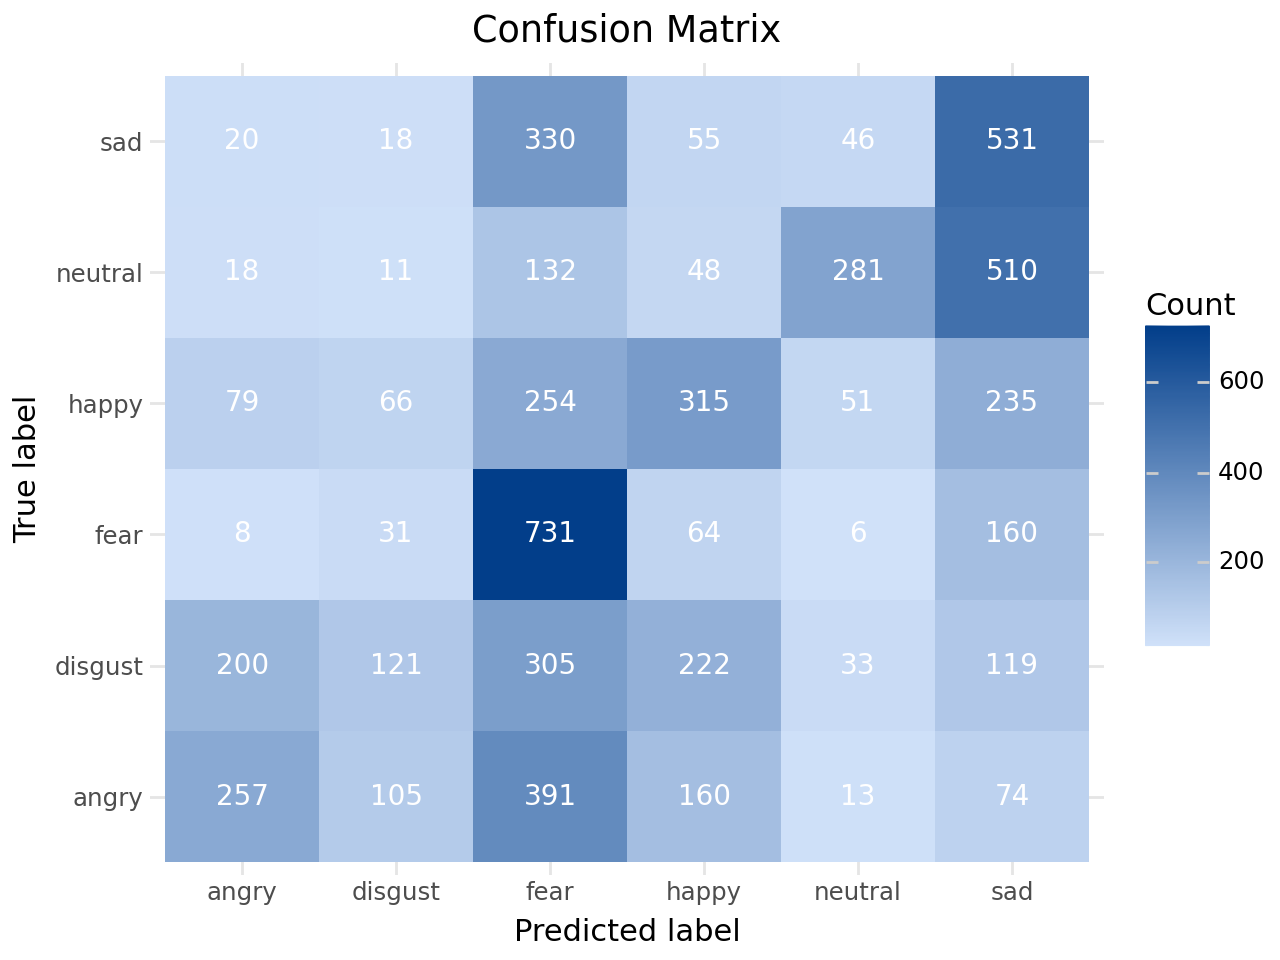


Confusion matrix plot generated!


In [6]:
import pandas as pd

df = pd.read_csv('../data/processed/audio_16k/subesco/metadata.csv')
file_paths = df["file_path"].tolist()

labels_dict = dict(zip(df['file_path'], df['emotion']))

true_labels = df["emotion"].tolist()

results, metrics = predictor.evaluate(
    file_paths=file_paths,
    true_labels=true_labels,
    batch_size=32,
    plot_cm=True,  # Generate visual confusion matrix
)

### Gathered Dataset

Predicting on 60 files...
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

2025-12-06 03:42:12.578496: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-06 03:42:12.578566: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-06 03:42:13.258867: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_190', 28 bytes spill stores, 28 bytes spill loads

2025-12-06 03:42:13.879563: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step

OVERALL METRICS
Accuracy:  0.3500 (35.00%)
Precision: 0.3519
Recall:    0.3500
F1 Score:  0.3234

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.25      0.10      0.14        10
     disgust       0.25      0.10      0.14        10
        fear       0.21      0.30      0.25        10
       happy       0.44      0.80      0.57        10
     neutral       0.67      0.40      0.50        10
         sad       0.29      0.40      0.33        10

    accuracy                           0.35        60
   macro avg       0.35      0.35      0.32        60
weighted avg       0.35      0.35      0.32        60



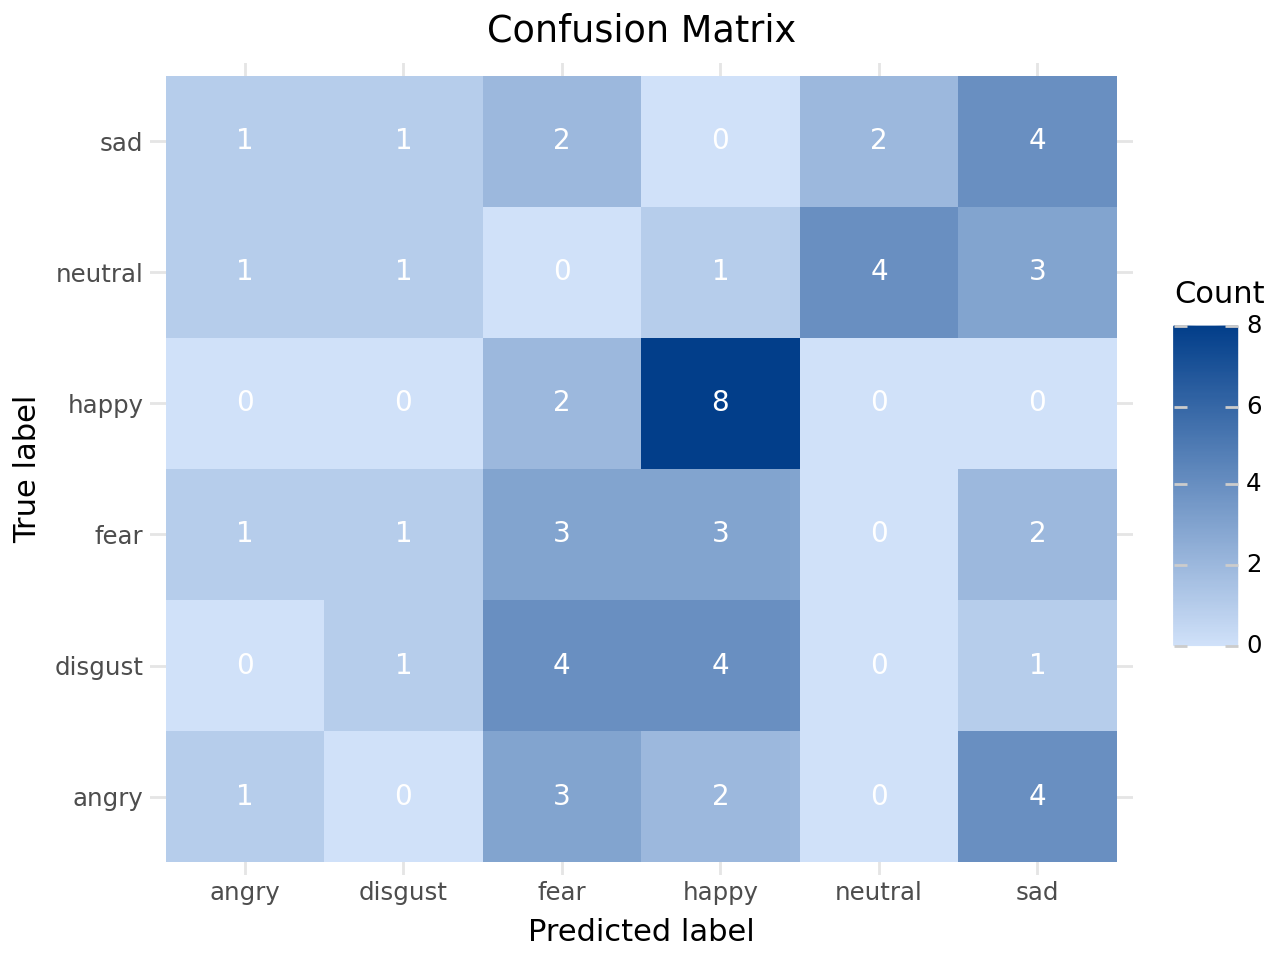


Confusion matrix plot generated!


In [4]:
import pandas as pd

df = pd.read_csv('../data/processed/audio_16k/gathered/metadata.csv')
file_paths = df["file_path"].tolist()

labels_dict = dict(zip(df['file_path'], df['emotion']))

true_labels = df["emotion"].tolist()

results, metrics = predictor.evaluate(
    file_paths=file_paths,
    true_labels=true_labels,
    batch_size=32,
    plot_cm=True,  # Generate visual confusion matrix
)

### Emodb Dataset

#### Get Predictions

Predicting on 454 files...
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 758ms/step

OVERALL METRICS
Accuracy:  0.5286 (52.86%)
Precision: 0.6301
Recall:    0.5286
F1 Score:  0.5208

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.80      0.68      0.74       127
     disgust       0.50      0.22      0.30        46
        fear       0.34      0.93      0.50        69
       happy       0.51      0.28      0.36        71
     neutral       0.89      0.30      0.45        79
         sad       0.50      0.58      0.54        62

    accuracy                           0.53       454
   macro avg       0.59      0.50      0.48       454
weighted avg       0.63      0.53      0.52       454



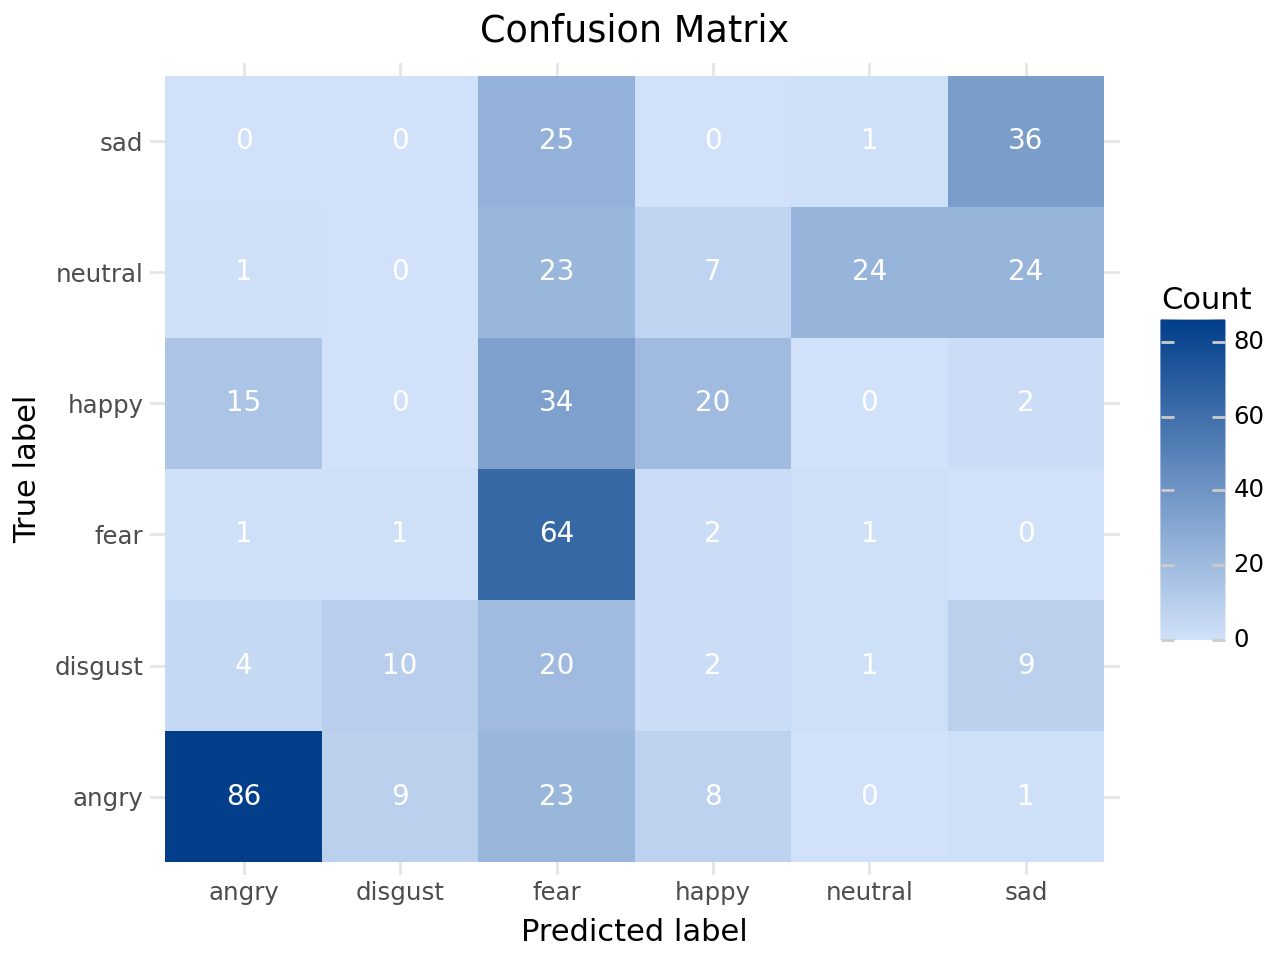


Confusion matrix plot generated!


In [8]:
import pandas as pd

df = pd.read_csv('../data/processed/audio_16k/emodb/metadata.csv')
file_paths = df["file_path"].tolist()

labels_dict = dict(zip(df['file_path'], df['emotion']))

true_labels = df["emotion"].tolist()

results, metrics = predictor.evaluate(
    file_paths=file_paths,
    true_labels=true_labels,
    batch_size=32,
    plot_cm=True,  # Generate visual confusion matrix
)